## RealNVP Example

**Note as of 20/10/2020** This notebook works with TFP 0.8 but it is assumned that it will change due to expected changes in the API of TFP.

**Goal:** This notebook shows how to wrap learnable flows into Keras **subclassing** `tf.keras.models.Model`. 

**Usage:** Try to understand the provided code.

**Dataset:** Two dimnesional artifical data.

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(5,5))
plt.style.use('default') 
plt.rcParams.update({'font.size': 15}) 


tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0
TF  Version 2.0.0


<Figure size 500x500 with 0 Axes>

### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

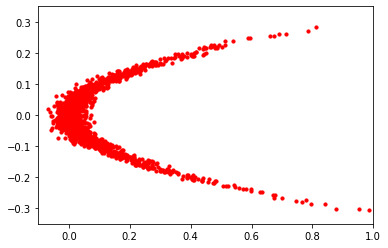

In [4]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem

# Adapted from: https://blog.evjang.com/2018/01/nf1.html
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0


X = sample_2(1500)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

### Makeing a Keras model

#### Subclassing a Keras model

We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`. Having the variables in a model. Keras takes care of holding the variables.

In [5]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []
        
        # Defining the bijector
        bijectors=[] #A
      
        h = 32
        for i in range(5): #B
            net = tfb.real_nvp_default_template(hidden_layers=[h, h])#C
            bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=net,num_masked=num_masked))#D
            bijectors.append(tfb.Permute([1,0])) #E
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(#F
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

model = RealNVP(output_dim=2, num_masked=1)
### Below is a bit magic stuff, concerning eager execution
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
print(model.summary())


#A List of bijectors
#B Stacking of 5 layers
#C Definition of the Network
#D A shift and flow with parameters from the network
#E Permutation of coordinates
#F Distribution using z with two independent Gaussians

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Model: "real_nvp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.85814 2.0599801540374756
100   -2.3713262 0.6978676319122314
200   -3.1256006 0.633293867111206
300   -3.141074 0.6267588138580322
400   -3.1627984 0.6201825141906738
500   -3.161898 0.7367000579833984
600   -3.1688569 0.6307051181793213
700   -3.1702569 0.731107234954834
800   -3.1610577 0.6375768184661865
900   -3.1610556 0.6308271884918213
1000   -3.1709516 0.6565625667572021



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



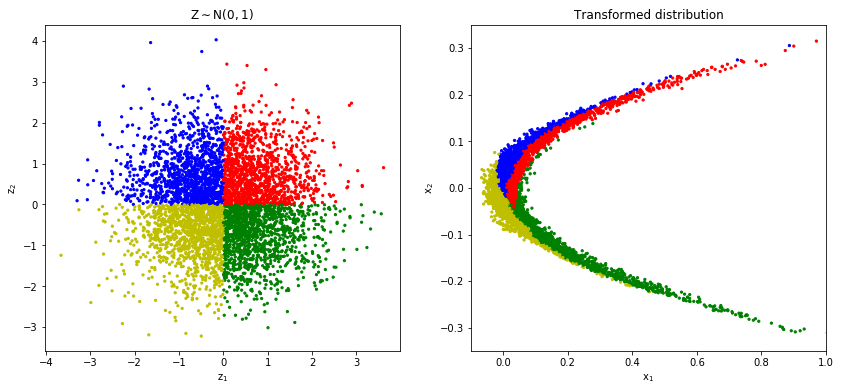

In [7]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.savefig('ch06_realnvp.pdf')

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" /> Now return the the main text for the final fun with glow section. We briefly mentioned that there is an aternative to RealNVP called (inverse auto regressive flow. If you are intersted in it the following code is using this alternative method.  

##### Autoregressive networks [just for reference]

For completeness, we also show the masked autoregressive networks, which we brieftly mentioned. 99% of the code below is just copy&past from above. Only in ome small section there is a difference.

In [8]:
class Mask_AR(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []
        
        # Defining the bijector
        bijectors=[] 
      
        h = 32
        for i in range(3): 
            
            ##### Here is some difference to RealNVP
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            #bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net)))
            #Uncommentung the line above (and commenting two lines above), would create a so-called inverse
            #autoregressive flow which is faster in prediction, but slower in training
            
            ##### End of difference
            
            bijectors.append(tfb.Permute([1,0])) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)


model = Mask_AR(output_dim=2, num_masked=1)
_ = model(X) 
print(model.summary())

Model: "mask_ar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 3,852
Trainable params: 3,852
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.8603338 1.1689496040344238
100   -0.9013051 0.40487241744995117
200   -2.7772157 0.40558552742004395
300   -2.9850042 0.4338057041168213
400   -3.0385306 0.4169611930847168
500   -3.0826547 0.42675352096557617
600   -3.1175244 0.43448519706726074
700   -3.1368954 0.4301440715789795
800   -3.1409888 0.42099714279174805
900   -3.145654 0.4307677745819092
1000   -3.1511843 0.4466276168823242



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.35, 0.35)

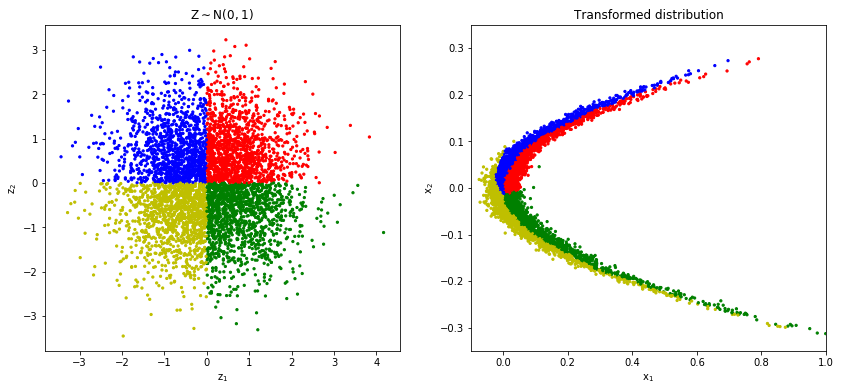

In [10]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
